In [ ]:
import torch
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import glob
import os
from IPython.display import display

In [ ]:
# Load the dataset for prediction
RSNA_df = pd.read_csv('/content/drive/MyDrive/RSNA-Lumber-Spine-Dataset/train.csv')
RSNA_coor = pd.read_csv('/content/drive/MyDrive/RSNA-Lumber-Spine-Dataset/train_label_coordinates.csv')
RSNA_coor = RSNA_coor.sort_values(['study_id', 'series_id', 'level'])
RSNA_coor['path_id'] = RSNA_coor.apply(lambda row: f"{row['study_id']}/{row['series_id']}", axis=1)
RSNA_coor = RSNA_coor.drop_duplicates(subset='study_id', keep='first').reset_index(drop=True)

In [ ]:
RSNA_coor

,study_id,series_id,instance_number,condition,level,x,y,path_id
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,4003253/702807833
1,4646740,3201256954,15,Right Subarticular Stenosis,L1/L2,184.180995,263.239819,4646740/3201256954
2,7143189,132939515,9,Spinal Canal Stenosis,L1/L2,177.938468,93.727402,7143189/132939515
3,8785691,481125819,8,Spinal Canal Stenosis,L1/L2,181.935484,96.487455,8785691/481125819
4,10728036,142859125,8,Left Subarticular Stenosis,L1/L2,290.555985,251.057915,10728036/142859125
...,...,...,...,...,...,...,...,...
1969,4282019580,121051321,11,Left Subarticular Stenosis,L1/L2,189.110807,179.917921,4282019580/121051321
1970,4283570761,453728183,9,Spinal Canal Stenosis,L1/L2,252.096578,148.066797,4283570761/453728183
1971,4284048608,1875151370,6,Right Neural Foraminal Narrowing,L1/L2,220.488728,147.169082,4284048608/1875151370
1972,4287160193,327893304,4,Left Neural Foraminal Narrowing,L1/L2,189.077757,113.105882,4287160193/327893304


In [ ]:
# Define dataset class
class PreTrainDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def load_img(self, image_path, target_size=(256, 256)):
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to load image at path: {image_path}")
            return None
        image_resized = cv2.resize(image, target_size)
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        image_transposed = np.transpose(image_rgb, (2, 0, 1)).astype(np.float32) / 255.0
        return image_transposed

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        st_id = self.df['study_id'][idx]
        num_sag = glob.glob(f'/conten')
        if len(num_sag) == 0:
            return {'img': torch.zeros(3, 256, 256)}
        center = len(num_sag) // 2
        formatted_center = f'{center:03}'
        path_sag = f'path_to_your/{st_id}/Sagittal T1/{formatted_center}.png'
        if not os.path.exists(path_sag):
            return {'img': torch.zeros(3, 256, 256)}
        img = self.load_img(path_sag)
        if img is None:
            img = torch.zeros(3, 256, 256)
        return {'img': img}

In [ ]:
# Load saved model weights
def load_weights_skip_mismatch(model, weights_path, device):
    state_dict = torch.load(weights_path, map_location=device)
    model_state_dict = model.state_dict()
    new_state_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}
    model_state_dict.update(new_state_dict)
    model.load_state_dict(model_state_dict)

In [ ]:
# Load model
import timm  # Assuming timm package is used for model creation
model = timm.create_model('resnet18', pretrained=True, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
weights_path = '/content/drive/MyDrive/resnet18.pt'
load_weights_skip_mismatch(model, weights_path, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

<ipython-input-5-b1ee0325061a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


In [ ]:
# Prediction function
def predict(model, data_loader, device):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            inputs = batch['img'].to(device).float()
            preds = model(inputs)
            preds = torch.sigmoid(preds)
            all_preds.append(preds.cpu().numpy())
    all_preds = np.concatenate(all_preds, axis=0)
    return all_preds

In [ ]:
# pip install timm

In [ ]:
# Visualize predictions
def plot_image_with_coords(image_path, coords):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at path: {image_path}")
        return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    x_coords = coords[::2]
    y_coords = coords[1::2]
    x_coords_actual = [x * width for x in x_coords]
    y_coords_actual = [y * height for y in y_coords]
    plt.figure(figsize=(5,5))
    plt.imshow(image_rgb)
    plt.axis('off')
    for x, y in zip(x_coords_actual, y_coords_actual):
        plt.plot(x, y, 'ro')
        plt.text(x, y, f'({x:.2f}, {y:.2f})', fontsize=12, color='white', ha='right')
    plt.show()

In [ ]:
# Load data and make predictions
train_ds = PreTrainDataset(RSNA_coor)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=False)
all_predictions = predict(model, train_dl, device)

100%|██████████| 124/124 [03:48<00:00,  1.84s/it]


In [ ]:
RSNA_coor

,study_id,series_id,instance_number,condition,level,x,y,path_id
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,4003253/702807833
1,4646740,3201256954,15,Right Subarticular Stenosis,L1/L2,184.180995,263.239819,4646740/3201256954
2,7143189,132939515,9,Spinal Canal Stenosis,L1/L2,177.938468,93.727402,7143189/132939515
3,8785691,481125819,8,Spinal Canal Stenosis,L1/L2,181.935484,96.487455,8785691/481125819
4,10728036,142859125,8,Left Subarticular Stenosis,L1/L2,290.555985,251.057915,10728036/142859125
...,...,...,...,...,...,...,...,...
1969,4282019580,121051321,11,Left Subarticular Stenosis,L1/L2,189.110807,179.917921,4282019580/121051321
1970,4283570761,453728183,9,Spinal Canal Stenosis,L1/L2,252.096578,148.066797,4283570761/453728183
1971,4284048608,1875151370,6,Right Neural Foraminal Narrowing,L1/L2,220.488728,147.169082,4284048608/1875151370
1972,4287160193,327893304,4,Left Neural Foraminal Narrowing,L1/L2,189.077757,113.105882,4287160193/327893304


In [ ]:
stid = RSNA_coor[RSNA_coor['study_id'] == 100206310]
stid

,study_id,series_id,instance_number,condition,level,x,y,path_id
45,100206310,1012284084,20,Left Subarticular Stenosis,L1/L2,180.355677,165.0342,100206310/1012284084


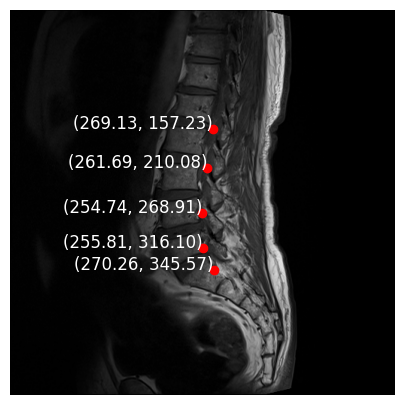

In [ ]:
 # Visualize example prediction
idx_plt = 45  # Select example index
stid = RSNA_coor.study_id[idx_plt]
num_sag = glob.glob(f'/content/drive/MyDrive/lsdcgcs/{stid}/Sagittal T1/*.png')
center = len(num_sag) // 2
formatted_center = f'{center:03}'
path_sag = f'/content/drive/MyDrive/lsdcgcs/{stid}/Sagittal T1/{formatted_center}.png'
CORD = all_predictions[idx_plt]
plot_image_with_coords(path_sag, CORD)